# 🫀 Heart Disease — Baseline Models
**Group-stratified CV · Sex×Surveillance-aware evaluation · Female FN tracking**

### Pipeline
1. Feature engineering (interactions + hr_reserve)
2. Group-stratified 5-fold CV (stratify on Sex×Surveillance)
3. LightGBM · XGBoost · CatBoost · Logistic Regression
4. Per-group evaluation — track Female/Naive false negative rate
5. Save OOF predictions for ensembling

---
## 1 · Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

# ── Paths ──────────────────────────────────────────────────────────────────
BASE = '/users/clairedebadts/kaggle/heart-disease-playground/data/'
df   = pd.read_csv(BASE + 'train_clean.csv')
test = pd.read_csv(BASE + 'test.csv')

print(f'Train: {df.shape}  |  Test: {test.shape}')
print('Train columns:', df.columns.tolist())


Train: (630000, 16)  |  Test: (270000, 14)
Train columns: ['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'target', 'under_surveillance']


---
## 2 · Rebuild Group Labels

In [2]:
# ── Rebuild group labels ──────────────────────────────────────────────────
df['sex_label'] = df['Sex'].map({1: 'Male', 0: 'Female'})
df['under_surveillance'] = (
    (df['Number of vessels fluro'] > 0) |
    (df['Thallium'] == 6) |
    (df['EKG results'] == 2)
).astype(int)
df['group'] = df['sex_label'] + ' / ' + df['under_surveillance'].map({0:'Naive', 1:'Surveilled'})

# Mirror on test
test['sex_label'] = test['Sex'].map({1: 'Male', 0: 'Female'})
test['under_surveillance'] = (
    (test['Number of vessels fluro'] > 0) |
    (test['Thallium'] == 6) |
    (test['EKG results'] == 2)
).astype(int)
test['group'] = test['sex_label'] + ' / ' + test['under_surveillance'].map({0:'Naive', 1:'Surveilled'})

print(df['group'].value_counts())


group
Male / Surveilled      296965
Male / Naive           153318
Female / Naive          90432
Female / Surveilled     89285
Name: count, dtype: int64


---
## 3 · Feature Engineering

In [3]:
# ── Feature engineering ───────────────────────────────────────────────────
def engineer_features(data):
    d = data.copy()
    d['sex_x_chest_pain']   = d['Sex'] * d['Chest pain type']
    d['sex_x_slope']        = d['Sex'] * d['Slope of ST']
    d['sex_x_max_hr']       = d['Sex'] * d['Max HR']
    d['surv_x_cholesterol'] = d['under_surveillance'] * d['Cholesterol']
    d['surv_x_max_hr']      = d['under_surveillance'] * d['Max HR']
    d['surv_x_bp']          = d['under_surveillance'] * d['BP']
    d['hr_reserve']         = (220 - d['Age']) - d['Max HR']
    return d

df   = engineer_features(df)
test = engineer_features(test)

print('Features added. New shape:', df.shape)


Features added. New shape: (630000, 25)


---
## 4 · Features, Weights & CV

In [4]:
# ── Feature cols, X, y, groups, weights ───────────────────────────────────
FEATURE_COLS = [c for c in df.columns if c not in
                ['id', 'target', 'sex_label', 'group', 'Heart Disease', 'sample_weight']]

X      = df[FEATURE_COLS].copy()
y      = df['target']
groups = df['group']

weight_map = {
    'Female / Naive':      4.0,
    'Female / Surveilled': 2.0,
    'Male / Naive':        1.5,
    'Male / Surveilled':   1.0,
}
sample_weights = groups.map(weight_map)

# Group-stratified CV
N_FOLDS      = 5
skf          = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
group_encoded = pd.Categorical(groups).codes

print(f'Features ({len(FEATURE_COLS)}): {FEATURE_COLS}')
print(f'Sample weight distribution:\n{sample_weights.value_counts()}')


Features (21): ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'under_surveillance', 'sex_x_chest_pain', 'sex_x_slope', 'sex_x_max_hr', 'surv_x_cholesterol', 'surv_x_max_hr', 'surv_x_bp', 'hr_reserve']
Sample weight distribution:
group
1.0    296965
1.5    153318
4.0     90432
2.0     89285
Name: count, dtype: int64


---
## 5 · Evaluation Helper

In [5]:
# ── Evaluation helper ─────────────────────────────────────────────────────
def evaluate_by_group(y_true, y_pred_proba, groups, threshold=0.5, verbose=True):
    y_pred  = (y_pred_proba >= threshold).astype(int)
    results = []
    for group in sorted(groups.unique()):
        mask = groups == group
        yt, yp, ypp = y_true[mask], y_pred[mask], y_pred_proba[mask]
        if yt.nunique() < 2:
            continue
        tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
        results.append({
            'group':      group,
            'n':          int(mask.sum()),
            'prevalence': round(yt.mean(), 3),
            'AUC':        round(roc_auc_score(yt, ypp), 4),
            'Recall':     round(recall_score(yt, yp, zero_division=0), 3),
            'Precision':  round(precision_score(yt, yp, zero_division=0), 3),
            'FN_rate':    round(fn / max(fn + tp, 1), 3),
        })
    result_df = pd.DataFrame(results).set_index('group')
    if verbose:
        print(result_df.to_string())
    return result_df


---
## 6 · Model Definitions

In [6]:
# ── Model definitions ─────────────────────────────────────────────────────
models = {
    'LightGBM': LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=63,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1,
    ),
    'XGBoost': XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        random_state=42,
        verbosity=0,
    ),
    'CatBoost': CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_seed=42,
        verbose=0,
    ),
    'LogisticRegression': Pipeline([
        ('scaler', RobustScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, C=1.0)),
    ]),
}


---
## 7 · Cross-Validation Loop

In [7]:
# ── Cross-validation loop ─────────────────────────────────────────────────
results_summary = {}
oof_preds       = {}

for model_name, model in models.items():
    print(f'\n{"="*55}')
    print(f'  {model_name}')
    print(f'{"="*55}')

    oof       = np.zeros(len(X))
    fold_aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, group_encoded)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        w_train        = sample_weights.iloc[train_idx]
        g_val          = groups.iloc[val_idx]

        if model_name == 'LogisticRegression':
            model.fit(X_train, y_train, **{'clf__sample_weight': w_train})
        elif model_name == 'LightGBM':
            model.fit(X_train, y_train,
                      sample_weight=w_train,
                      eval_set=[(X_val, y_val)],
                      callbacks=[])
        elif model_name == 'CatBoost':
            model.fit(X_train, y_train,
                      sample_weight=w_train,
                      eval_set=(X_val, y_val),
                      use_best_model=True)
        else:  # XGBoost
            model.fit(X_train, y_train,
                      sample_weight=w_train,
                      eval_set=[(X_val, y_val)],
                      verbose=False)

        val_proba     = model.predict_proba(X_val)[:, 1]
        oof[val_idx]  = val_proba
        fold_auc      = roc_auc_score(y_val, val_proba)
        fold_aucs.append(fold_auc)
        print(f'  Fold {fold+1}: AUC = {fold_auc:.4f}')

    mean_auc = np.mean(fold_aucs)
    std_auc  = np.std(fold_aucs)
    print(f'\n  CV AUC: {mean_auc:.4f} ± {std_auc:.4f}')
    print(f'\n  Per-group evaluation (OOF, threshold=0.5):')
    group_results = evaluate_by_group(y, oof, groups, threshold=0.5)

    results_summary[model_name] = {
        'cv_auc_mean':   mean_auc,
        'cv_auc_std':    std_auc,
        'group_results': group_results,
    }
    oof_preds[model_name] = oof



  LightGBM
  Fold 1: AUC = 0.9554
  Fold 2: AUC = 0.9539
  Fold 3: AUC = 0.9552
  Fold 4: AUC = 0.9550
  Fold 5: AUC = 0.9541

  CV AUC: 0.9547 ± 0.0006

  Per-group evaluation (OOF, threshold=0.5):
                          n  prevalence     AUC  Recall  Precision  FN_rate
group                                                                      
Female / Naive        90432       0.080  0.9188   0.451      0.733    0.549
Female / Surveilled   89285       0.278  0.9462   0.776      0.839    0.224
Male / Naive         153318       0.310  0.9195   0.732      0.804    0.268
Male / Surveilled    296965       0.683  0.9433   0.927      0.904    0.073

  XGBoost
  Fold 1: AUC = 0.9555
  Fold 2: AUC = 0.9540
  Fold 3: AUC = 0.9554
  Fold 4: AUC = 0.9553
  Fold 5: AUC = 0.9542

  CV AUC: 0.9549 ± 0.0006

  Per-group evaluation (OOF, threshold=0.5):
                          n  prevalence     AUC  Recall  Precision  FN_rate
group                                                                

---
## 8 · Summary Table

In [8]:
# ── Summary table ─────────────────────────────────────────────────────────
print('\n' + '='*55)
print('  MODEL COMPARISON SUMMARY')
print('='*55)

summary_df = pd.DataFrame({
    name: {
        'CV AUC (mean)':   f"{v['cv_auc_mean']:.4f}",
        'CV AUC (std)':    f"±{v['cv_auc_std']:.4f}",
        'FN Female/Naive': v['group_results'].loc['Female / Naive', 'FN_rate']
                           if 'Female / Naive' in v['group_results'].index else 'N/A',
    }
    for name, v in results_summary.items()
}).T
print(summary_df.to_string())



  MODEL COMPARISON SUMMARY
                   CV AUC (mean) CV AUC (std) FN Female/Naive
LightGBM                  0.9547      ±0.0006           0.549
XGBoost                   0.9549      ±0.0006           0.546
CatBoost                  0.9553      ±0.0006           0.552
LogisticRegression        0.9505      ±0.0006           0.587


---
## 9 · Visualisation

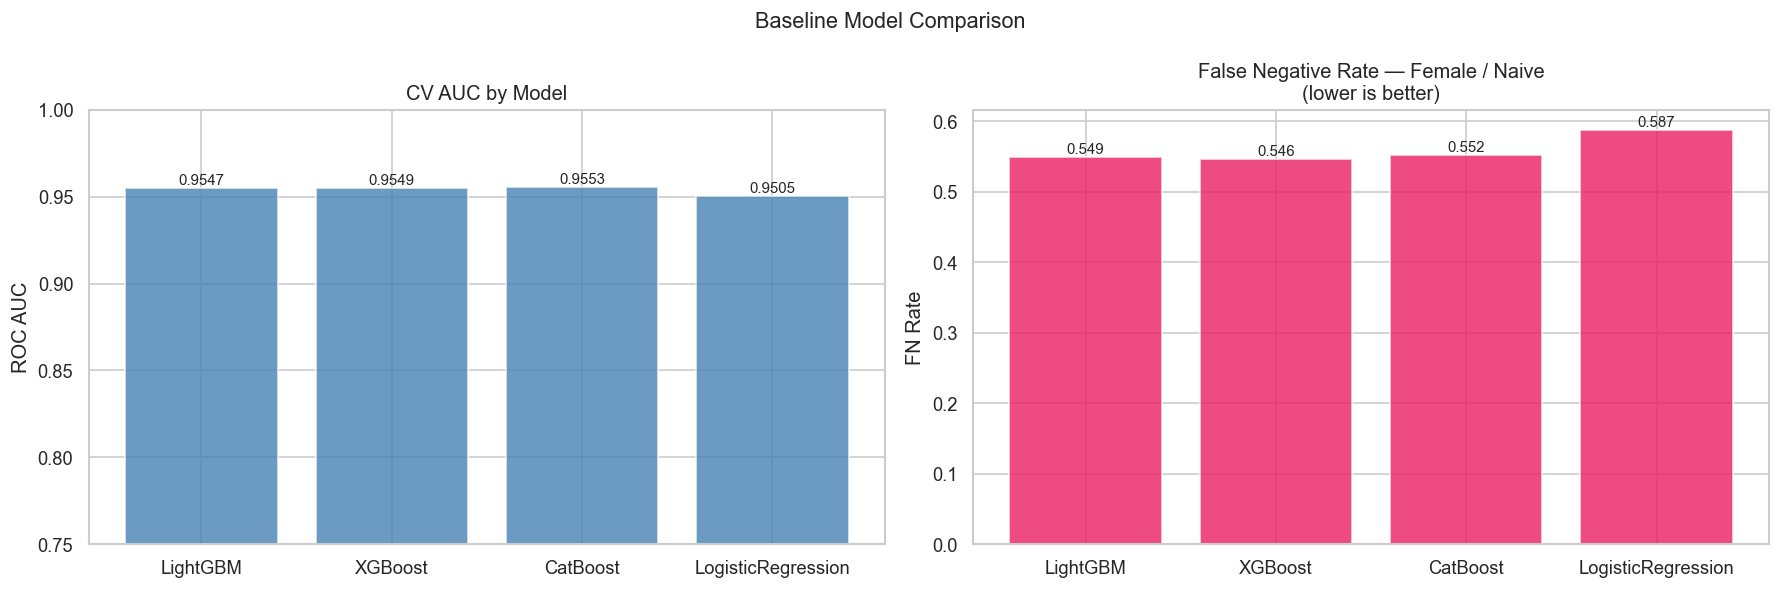

In [9]:
# ── Visualisation ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: CV AUC
auc_data = {name: v['cv_auc_mean'] for name, v in results_summary.items()}
axes[0].bar(auc_data.keys(), auc_data.values(), color='steelblue', alpha=0.8)
axes[0].set_ylim(0.75, 1.0)
axes[0].set_title('CV AUC by Model')
axes[0].set_ylabel('ROC AUC')
for i, (name, val) in enumerate(auc_data.items()):
    axes[0].text(i, val + 0.002, f'{val:.4f}', ha='center', fontsize=9)

# Right: Female/Naive FN rate
fn_data = {
    name: v['group_results'].loc['Female / Naive', 'FN_rate']
    for name, v in results_summary.items()
    if 'Female / Naive' in v['group_results'].index
}
axes[1].bar(fn_data.keys(), fn_data.values(), color='#E91E63', alpha=0.8)
axes[1].set_title('False Negative Rate — Female / Naive\n(lower is better)')
axes[1].set_ylabel('FN Rate')
for i, (name, val) in enumerate(fn_data.items()):
    axes[1].text(i, val + 0.005, f'{val:.3f}', ha='center', fontsize=9)

plt.suptitle('Baseline Model Comparison', fontsize=13)
plt.tight_layout()
plt.show()


---
## 10 · Save OOF Predictions

In [10]:
# ── Save OOF predictions for ensembling ───────────────────────────────────
oof_df          = pd.DataFrame(oof_preds, index=df.index)
oof_df['target'] = y.values
oof_df['group']  = groups.values
oof_df.to_csv(BASE + 'oof_predictions.csv', index=False)
print('✅ Saved oof_predictions.csv')


✅ Saved oof_predictions.csv
